# 3-D Pose Estimation using GANs

This notebook is the python implementation of 3-D pose estimation from 2-D joint poses inspired by the research paper [Unsupervised adversarial learning of 3d human pose from 2d joint locations](https://arxiv.org/pdf/1803.08244.pdf) 


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchsummary import summary
import random
import json
import glob 
from mpl_toolkits import mplot3d
import datetime

import plotly.express as px
import plotly.graph_objects as go

import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [4]:
full_path = "/content/drive/MyDrive/CIS 581 Final Project/Project/Full MPII Dataset/JSON_Output_partcandidates/*.json"
small_path = "/content/drive/MyDrive/CIS 581 Final Project/finalproj/*.json"
dataset_path = "/content/drive/MyDrive/CIS 581 Final Project/Project/full_dataset.npy"

In [5]:
def normalise(dataset):
  central_pt_idx = 8

  normalised_data = np.zeros(dataset.shape)
  norm_data = np.zeros(dataset.shape)

  for i in range(len(dataset)):
    diff = dataset[i]-dataset[i][central_pt_idx]
    norm_data[i] = dataset[i]/np.mean(np.linalg.norm(diff))
    normalised_data[i] = norm_data[i]-norm_data[i][central_pt_idx]

  return torch.FloatTensor(normalised_data)

In [6]:
n_joints = 15 
## Get dataset here: https://drive.google.com/drive/folders/1KspHx3-lD5pZWQlcUcq0wzOF7wSmM9iP?usp=sharing ##

dataset = np.load(dataset_path)[:,:15,:]
dataset = normalise(dataset)
print (dataset.shape)

torch.Size([52647, 15, 2])


In [7]:
train_size = 3000
test_size = len(dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [8]:
batch_size = 64
workers = 2
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class MLP_Generator(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    hiddensize = 1024
    self.layer1 = nn.Linear(input_size, hiddensize)
    self.layer2 = nn.Linear(hiddensize, hiddensize)
    self.layer3 = nn.Linear(hiddensize, hiddensize)
    self.out_layer = nn.Linear(hiddensize, output_size)
    self.leaky_relu = nn.LeakyReLU()

  def forward(self, x):
    x1 = self.layer1(x)
    x1 = self.leaky_relu(x1)

    x2 = self.layer2(x1)
    x2 = self.leaky_relu(x2)

    x2 = self.layer3(x2)
    x3 = self.leaky_relu(x2+x1)
    x3 = self.out_layer(x3)
    return x3

In [10]:
class MLP_Discriminator(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    hiddensize = 1024
    self.layer1 = nn.Linear(input_size, hiddensize)
    self.layer2 = nn.Linear(hiddensize, hiddensize)
    self.layer3 = nn.Linear(hiddensize, hiddensize)
    self.out_layer = nn.Linear(hiddensize, output_size)
    self.leaky_relu = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x1 = self.layer1(x)
    x1 = self.leaky_relu(x1)

    x2 = self.layer2(x1)
    x2 = self.leaky_relu(x2)

    x2 = self.layer3(x2)
    x3 = self.leaky_relu(x2+x1)
    x3 = self.out_layer(x3)
    # convert to binary preds 0-1 for BCE Loss
    x3 = self.sigmoid(x3)
    return x3

In [11]:
def rotate_project(realpose2d, z_predicted_gen):
  # return projected 2D pose from the genertaor's 3D pose after a random theta rotation
  n_joints =  z_predicted_gen.shape[1]
  batchsize = z_predicted_gen.shape[0]
  x = realpose2d[:, 0:n_joints]
  y = realpose2d[:, n_joints:]

  theta = np.random.default_rng().uniform(0, 2 * np.pi, batchsize).reshape(-1, 1)
  cos_theta = torch.FloatTensor(np.cos(theta)).to(device)
  sin_theta = torch.FloatTensor(np.sin(theta)).to(device)

  x_new = x * cos_theta + z_predicted_gen * sin_theta
  y_new = y

  fake2dpose = torch.cat((x_new, y_new), axis=1)

  return fake2dpose


In [12]:
def L_angle(z, xy):
  # Additional loss component to avoid inverted 3D poses
  #neck->nose
  f_z = z[:,1] - z[:,0]
  f_x = xy[:,1] - xy[:,0]
  f_n = torch.sqrt(f_z**2 + f_x**2)

  #right shoulder->left shoulder
  s_z = z[:,2] - z[:,5]
  s_x = xy[:,2] - xy[:,5]
  s_n = torch.sqrt(s_z**2 + s_x**2)

  sin_beta = (f_z*s_x - f_x*s_z) / (f_n*s_n)
  l_angle = F.relu(-sin_beta)

  return torch.mean(l_angle)

In [13]:
train = False   # Make train true if you need to rerun training
gen_model = []
desc_model = []

gen_model_path = "/content/drive/MyDrive/CIS 581 Final Project/Project/Full MPII Dataset/Gen_model_2021-12-07 08:29:15.882010"
desc_model_path = "/content/drive/MyDrive/CIS 581 Final Project/Project/Full MPII Dataset/Discr_model_2021-12-07 08:29:15.922339"

if not train:  # Make train false to load pre-trained models
  gen_model = torch.load(gen_model_path, map_location=device)
  desc_model = torch.load(desc_model_path, map_location=device)

  print (gen_model, desc_model)


MLP_Generator(
  (layer1): Linear(in_features=30, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (out_layer): Linear(in_features=1024, out_features=15, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
) MLP_Discriminator(
  (layer1): Linear(in_features=30, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (out_layer): Linear(in_features=1024, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)


In [14]:
import warnings
warnings.filterwarnings('ignore')

if train:     ### Make train true if you need to rerun training
  epochs = 30
  vis_const = 100
  input_size = n_joints*2 # x and y flattened
  gen_model = MLP_Generator(input_size, n_joints).to(device)
  desc_model = MLP_Discriminator(input_size, 1).to(device)

  criterion = nn.BCELoss()
  gen_optimizer = optim.Adam(gen_model.parameters(), lr=5e-5) 
  desc_optimizer = optim.Adam(desc_model.parameters(), lr=1e-5)

  train_running_loss_desc = []
  train_running_loss_gen = []

  for epoch in range(epochs):
      running_loss_desc = 0
      running_loss_gen = 0
      for i, pose in enumerate(train_dataloader, 0):
          pose2d = pose.view(-1, input_size).to(device)

          ## Descriminator ##
          # zero gradient
          desc_optimizer.zero_grad()

          # get fake preds from generator and adapt them
          z_predicted_gen = gen_model(pose2d)
          fake2dposes = rotate_project(pose2d, z_predicted_gen)

          # descrimintor input: append real pose2d and fake2dposes with correct labels 
          all_labels = torch.zeros(pose2d.shape[0]*2, 1).to(device)
          all_labels[0:pose2d.shape[0]] = 1
          input_to_desc = torch.cat((pose2d, fake2dposes), dim=0).to(device)

          # Get discriminator predictions and backprop
          y_predicted_desc = desc_model(input_to_desc)
          loss_desc = criterion(y_predicted_desc, all_labels)
          running_loss_desc += loss_desc.item()
          loss_desc.backward()
          desc_optimizer.step()

          ## Generator ##
          #Take multiple generator steps for each descriminator step
          gen_loss_steps = []
          gen_steps = 70
          for k in range(0, gen_steps):
            # zero gradient
            gen_optimizer.zero_grad()

            # again get fake preds from generator and adapt them
            z_predicted_gen = gen_model(pose2d)
            fake2dposes = rotate_project(pose2d, z_predicted_gen)

            # Get discriminator predictions on the fake poses and try to get them predicted as real (so labels=1)
            y_predicted_desc = desc_model(fake2dposes)
            labels =  torch.ones(pose2d.shape[0], 1).to(device)

            loss_gen = criterion(y_predicted_desc, labels) + L_angle(z_predicted_gen, pose2d).to(device) 
            gen_loss_steps.append(loss_gen.item())
            loss_gen.backward()
            gen_optimizer.step()
          
          running_loss_gen+= np.average(gen_loss_steps)
          

      train_running_loss_desc.append(running_loss_desc)
      train_running_loss_gen.append(running_loss_gen)

      if (epoch+1) % 3 == 0:
          print(f'epoch: {epoch+1}, desc_loss: {running_loss_desc:.4f}, gen_loss: {running_loss_gen:.4f}, overall_loss: {running_loss_desc+running_loss_gen:.4f}')
  
  
  torch.save(gen_model, gen_model_path+str(datetime.datetime.now()))
  torch.save(desc_model, desc_model_path+str(datetime.datetime.now()))

In [15]:
def visualise2dpose(x, y):
  fig = plt.figure()
  plt.scatter(x, y)
  for i in range(0, n_joints):
    plt.annotate(i, (x[i], y[i]))

  plt.plot(x[0:2], y[0:2], 'go-')
  plt.plot(x[1:3], y[1:3], 'ro-')
  plt.plot(x[2:4], y[2:4], 'ro-')
  plt.plot(x[3:5], y[3:5], 'ro-')

  plt.plot(x[5:7], y[5:7], 'ro-')
  plt.plot(x[6:8], y[6:8], 'ro-')

  plt.plot([x[1],x[5]],[y[1],y[5]],'ro-')
  plt.plot([x[1],x[8]],[y[1],y[8]],'go-')

  plt.plot([x[8],x[9]],[y[8],y[9]],'k-')
  plt.plot([x[8],x[12]],[y[8],y[12]],'k-')
  plt.plot([x[9],x[10]],[y[9],y[10]],'k-')
  plt.plot([x[12],x[13]],[y[12],y[13]],'k-')

  plt.plot([x[10],x[11]],[y[10],y[11]],'k-')
  plt.plot([x[13],x[14]],[y[13],y[14]],'k-')

  plt.show()


In [16]:
def visualise3dpose(x, y, z):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter3D(x, y, z)
  for i in range(0, n_joints):
    ax.text3D(x[i], y[i], z[i], i)

  plt.plot(x[0:2], y[0:2], z[0:2], 'go-')
  plt.plot(x[1:3], y[1:3], z[1:3], 'ro-')
  plt.plot(x[2:4], y[2:4], z[2:4], 'ro-')
  plt.plot(x[3:5], y[3:5], z[3:5], 'ro-')

  plt.plot(x[5:7], y[5:7], z[5:7], 'ro-')
  plt.plot(x[6:8], y[6:8], z[6:8], 'ro-')

  plt.plot([x[1],x[5]],[y[1],y[5]], [z[1],z[5]], 'ro-')
  plt.plot([x[1],x[8]],[y[1],y[8]], [z[1],z[8]], 'go-')

  plt.plot([x[8],x[9]],[y[8],y[9]], [z[8],z[9]],'k-')
  plt.plot([x[8],x[12]],[y[8],y[12]],[z[8],z[12]],'k-')
  plt.plot([x[9],x[10]],[y[9],y[10]],[z[9],z[10]],'k-')
  plt.plot([x[12],x[13]],[y[12],y[13]],[z[12],z[13]],'k-')

  plt.plot([x[10],x[11]],[y[10],y[11]],[z[10],z[11]],'k-')
  plt.plot([x[13],x[14]],[y[13],y[14]],[z[13],z[14]],'k-')
  
  ax.set_xlim3d(min(x), max(x), 0.05)
  ax.set_ylim3d(min(y), max(y), 0.05)
  ax.set_zlim3d(min(z), max(z), 0.05)

  plt.show()

In [17]:
def visualise3dpose_plotly(x, y, z):
  n_joints = 15
  i = list(np.arange(0,n_joints))
  
  fig = go.Figure(data=[go.Scatter3d(x=x[:n_joints], y=y[:n_joints], z=z[:n_joints], text= i, 
                                   mode='markers')])
  

  
  figb = go.Figure(data=[go.Scatter3d(x=[x[0]], y=[y[0]], z=[z[0]], text= 0,
                                   mode='markers', 
                                   marker=dict(color='#E3BC9A',size=26))])

  fig2 = px.line_3d(x = x[0:2], y = y[0:2], z = z[0:2])
  fig2.update_traces(line=dict(color = '#FF0080', width = 13))
  fig3 = px.line_3d(x= x[1:3], y = y[1:3], z = z[1:3])
  fig3.update_traces(line=dict(color = '#FD7F20', width =13))
  fig4 = px.line_3d(x = x[2:4], y= y[2:4], z = z[2:4])
  fig4.update_traces(line=dict(color = '#FDB750', width =13))
  fig5 = px.line_3d(x = x[3:5], y = y[3:5], z =z[3:5])
  fig5.update_traces(line=dict(color = '#ECF87F', width =13))
  fig6 = px.line_3d(x = x[5:7], y = y[5:7], z = z[5:7])
  fig6.update_traces(line=dict(color = '#2C5E1A', width =13))
  fig7 = px.line_3d(x = x[6:8], y = y[6:8], z = z[6:8])
  fig7.update_traces(line=dict(color = '#1A4314', width=13 ))
  fig8 = px.line_3d( x =[x[1],x[5]],y =[y[1],y[5]], z = [z[1],z[5]])
  fig8.update_traces(line=dict(color = '#32CD32', width =13))
  fig9 = px.line_3d( x =[x[1],x[8]],y = [y[1],y[8]], z =  [z[1],z[8]])
  fig9.update_traces(line=dict(color = '#ff0000', width = 25))
  fig10 = px.line_3d( x =[x[8],x[9]],y = [y[8],y[9]], z = [z[8],z[9]])
  fig10.update_traces(line=dict(color = '#00c579', width =15))
  fig11 = px.line_3d( x =[x[8],x[12]],y = [y[8],y[12]], z = [z[8],z[12]])
  fig11.update_traces(line=dict(color = '#00ffff', width = 15))
  fig12 = px.line_3d( x =[x[9],x[10]], y =  [y[9],y[10]], z = [z[9],z[10]])
  fig12.update_traces(line=dict(color = '#009e61', width =15))
  fig17 = px.line_3d( x = [x[10],x[11]], y = [y[10],y[11]], z = [z[10],z[11]])
  fig17.update_traces(line=dict(color = '#2db4af', width =15))
  fig13 = px.line_3d( x =[x[12],x[13]],y = [y[12],y[13]], z = [z[12],z[13]])
  fig13.update_traces(line=dict(color = '#216bd6', width = 15))
  fig14 = px.line_3d( x =[x[13],x[14]], y= [y[13],y[14]], z = [z[13],z[14]])
  fig14.update_traces(line=dict(color = '#1a56ab', width = 15))


  figa = go.Figure(data=fig.data + figb.data + fig2.data + fig3.data + fig4.data +fig5.data +fig6.data + fig7.data +fig8.data +
                   fig9.data + fig10.data + fig11.data +fig12.data + fig13.data + fig14.data 
                   + fig17.data )


  figa.update_layout( scene=dict(annotations = [                                             
                                                 dict(showarrow=True, x = x[0],y = y[0], z=z[0], text = 0),
                                                 dict(showarrow=True, x = x[1],y = y[1], z=z[1], text = 1), 
                                                 dict(showarrow=True, x = x[2],y = y[2], z=z[2], text = 2),
                                                 dict(showarrow=True, x = x[3],y = y[3], z=z[3], text = 3),
                                                 dict(showarrow=True, x = x[4],y = y[4], z=z[4], text = 4),
                                                 dict(showarrow=True, x = x[5],y = y[5], z=z[5], text = 5),
                                                 dict(showarrow=True, x = x[6],y = y[6], z=z[6], text = 6),
                                                 dict(showarrow=True, x = x[7],y = y[7], z=z[7], text = 7),
                                                 dict(showarrow=True, x = x[8],y = y[8], z=z[8], text = 8),
                                                 dict(showarrow=True, x = x[9],y = y[9], z=z[9], text = 9),
                                                 dict(showarrow=True, x = x[10],y = y[10], z=z[10], text = 10),
                                                 dict(showarrow=True, x = x[11],y = y[11], z=z[11], text = 11),
                                                 dict(showarrow=True, x = x[12],y = y[12], z=z[12], text = 12),
                                                 dict(showarrow=True, x = x[13],y = y[13], z=z[13], text = 13),
                                                 dict(showarrow=True, x = x[14],y = y[14], z=z[14], text = 14)]
                                                   ,xaxis = dict(nticks = int((max(x)-min(x))/0.01), range =[min(x),max(x)]), 
                                                    yaxis = dict(nticks = int((max(y)-min(y))/0.01), range =[min(y),max(y)]),
                                                    zaxis = dict(nticks = int((max(z)-min(z))/0.01), range =[min(z),max(z)])
                                                 ))
  figa.show()


In [18]:
dataset = np.load("/content/drive/MyDrive/CIS 581 Final Project/Project/test_dataset.npy")
images = np.load("/content/drive/MyDrive/CIS 581 Final Project/Project/test_dataset2.npy")
image_path = "/content/drive/MyDrive/CIS 581 Final Project/Project/MPII Dataset/"


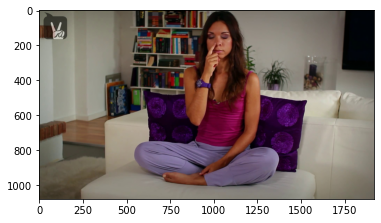

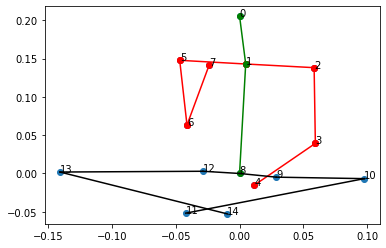

In [21]:
import matplotlib.image as mpimg
i = 1
img = mpimg.imread(image_path+images[i])
img2 = np.fliplr(img)
plt.imshow(img2, origin='upper')
dataset = normalise(dataset)

x, y = -dataset[i, :n_joints, 0], -dataset[i, :n_joints, 1]
visualise2dpose(x, y)

x, y = -dataset[i, :n_joints, 0].cpu().detach().numpy(), -dataset[i, :n_joints, 1].cpu().detach().numpy()

pose2d = torch.FloatTensor(np.vstack((x, y)).T).reshape(1, -1).to(device)
z = gen_model(pose2d).cpu().detach().numpy()[0]


In [22]:
visualise3dpose_plotly(z,x,y)